In [1]:
#Import packages used here:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# setup my directories
train_directory = 'train_data'
test_directory = 'test_data'
val_directory = 'val_data'

In [31]:
# Path to the "Spectograms" folder
spectrogram_folder = "Spectograms"

# Initialize counts for total items, folders with 10 or more items, and total classes
total_items = 0
folders_with_10_or_more_items = 0
total_classes = 0

# Iterate through the subfolders in the "Spectograms" folder
for root, dirs, files in os.walk(spectrogram_folder):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        num_items = len(os.listdir(folder_path))
        total_items += num_items

        if num_items >= 10:
            folders_with_10_or_more_items += 1

        total_classes += 1

        print(f"Folder: {folder}, Number of items: {num_items}")

# Print the total count of items, folders with 10 or more items, and total classes
print(f"Total items in all folders: {total_items}")
print(f"Folders with 10 or more items: {folders_with_10_or_more_items}")
print(f"Total classes: {total_classes}")

Folder: Carpodacus, Number of items: 497
Folder: Luscinia, Number of items: 498
Folder: Podiceps, Number of items: 499
Folder: Bucephala, Number of items: 310
Folder: Cygnus, Number of items: 499
Folder: Acanthis, Number of items: 500
Folder: Glaucidium, Number of items: 500
Folder: Pluvialis, Number of items: 499
Folder: Hydroprogne, Number of items: 363
Folder: Zenaida, Number of items: 501
Folder: Sylvia, Number of items: 500
Folder: Anas, Number of items: 499
Folder: Pipilo, Number of items: 500
Folder: Calcarius, Number of items: 500
Folder: Cinclus, Number of items: 345
Folder: Panurus, Number of items: 365
Folder: Buteo, Number of items: 499
Folder: Perdix, Number of items: 336
Folder: Ardea, Number of items: 500
Folder: Spatula, Number of items: 500
Folder: Pica, Number of items: 499
Folder: Prunella, Number of items: 500
Folder: Parus, Number of items: 499
Folder: Oriolus, Number of items: 473
Folder: Cyanocitta, Number of items: 500
Folder: Calandrella, Number of items: 380
F

In [4]:
categories = os.listdir(train_directory) # list the names of the categories that in my data
print(str(len(categories)),'CATEGORIES are ', categories)

category_count = len(categories)
# we will use "category_count" as the number of classes that we need to classify instead of typing 525 because the data is continuously increasing

119 CATEGORIES are  ['Carpodacus', 'Luscinia', 'Podiceps', 'Bucephala', 'Cygnus', 'Acanthis', 'Glaucidium', 'Pluvialis', 'Hydroprogne', 'Zenaida', 'Sylvia', 'Anas', 'Pipilo', 'Calcarius', 'Cinclus', 'Panurus', 'Buteo', 'Perdix', 'Ardea', 'Spatula', 'Pica', 'Prunella', 'Parus', 'Oriolus', 'Cyanocitta', 'Calandrella', 'Stercorarius', 'Rallus', 'Sternula', 'Branta', 'Actitis', 'Sitta', 'Picoides', 'Mareca', 'Chroicocephalus', 'Melanerpes', 'Sterna', 'Iduna', 'Anser', 'Nucifraga', 'Eurystomus', 'Bombycilla', 'Pitta', 'Sonus', 'Dendrocopos', 'Riparia', 'Jynx', 'Numenius', 'Pinicola', 'Garrulus', 'Cecropis', 'Porzana', 'Picus', 'Nycticorax', 'Limosa', 'Calidris', 'Lanius', 'Phylloscopus', 'Oenanthe', 'Calypte', 'Pyrrhocorax', 'Lullula', 'Lyrurus', 'Phalacrocorax', 'Fringilla', 'Troglodytes', 'Falco', 'Chrysococcyx', 'Milvus', 'Haliaeetus', 'Hirundo', 'Aythya', 'Locustella', 'Ficedula', 'Spinus', 'Merops', 'Alcedo', 'Dryobates', 'Aegithalos', 'Poecile', 'Apus', 'Anthus', 'Remiz', 'Myiopsitta'

In [5]:
general_datagen = ImageDataGenerator(rescale = 1./255) # for training, validation and testing data

train_generator = general_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    batch_size = 32
)
valid_generator = general_datagen.flow_from_directory(
    val_directory,
    target_size = (224, 224),
    batch_size = 32
)
test_generator = general_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False
)

Found 37726 images belonging to 119 classes.
Found 8049 images belonging to 119 classes.
Found 8165 images belonging to 119 classes.


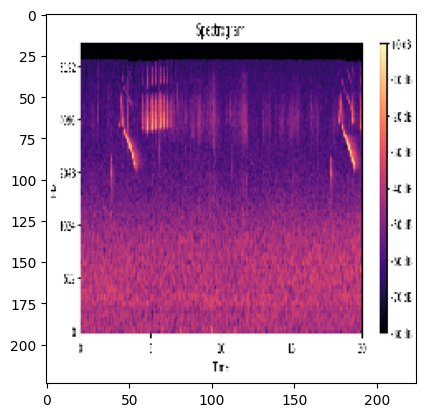

In [6]:
# ploting a sample from my data
def plot_image(generator):
    images_in_batch = next(generator) # images_in_batch will output (batch_size, height, width, n_channels)
    img = images_in_batch[0][0] # img will output (height, width, n_chennels)
    
    plt.imshow(img)

plot_image(train_generator)

In [7]:
# i will be using it to determine steps_per_epoch in my models.
train_groups = len(train_generator) 
valid_groups = len(valid_generator) # validation_step

print(f"Train groups: {train_groups}")
print(f"Validation groups: {valid_groups}")

Train groups: 1179
Validation groups: 252


In [8]:
# this dense layer i will not only use it for my base model i will use it in the pretrained model too
def dense_layer(inputs, out, dropout_rate = 0.5):
    x = layers.Dense(out)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    
    return x

In [9]:
keras.backend.clear_session()

base_mobilenet = keras.applications.MobileNet(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (224, 224, 3)
)
base_mobilenet.trainable = False

inputs = keras.Input(shape = (224, 224, 3))

x = base_mobilenet(inputs)

x = layers.Flatten()(x)

x = dense_layer(x, 512)
x = dense_layer(x, 256)
x = dense_layer(x, 128)

outputs = layers.Dense(category_count, activation = "softmax")(x)
mobilenet_model = keras.Model(inputs, outputs)

2023-12-11 10:45:23.690845: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.01),
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"]
)
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
    
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    
    keras.callbacks.ModelCheckpoint( filepath = "mobilenet_model.keras",save_best_only = True,monitor = "val_loss")
]
history = mobilenet_model.fit( 
    train_generator, 
    steps_per_epoch = train_groups, 
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=callbacks
)


Epoch 1/20
1179/1179 [==============================] - 841s 711ms/step - loss: 3.4418 - accuracy: 0.2199 - val_loss: 2.6469 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 2/20
1179/1179 [==============================] - 838s 710ms/step - loss: 2.4603 - accuracy: 0.3920 - val_loss: 2.4487 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 3/20
1179/1179 [==============================] - 812s 688ms/step - loss: 1.9999 - accuracy: 0.4886 - val_loss: 2.4063 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 4/20
1179/1179 [==============================] - 803s 681ms/step - loss: 1.5968 - accuracy: 0.5773 - val_loss: 2.3543 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 5/20
1179/1179 [==============================] - 807s 685ms/step - loss: 1.2597 - accuracy: 0.6569 - val_loss: 2.4338 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 6/20
1179/1179 [==============================] - ETA: 0s - loss: 0.9782 - accuracy: 0.7226
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1179/1179 [==========

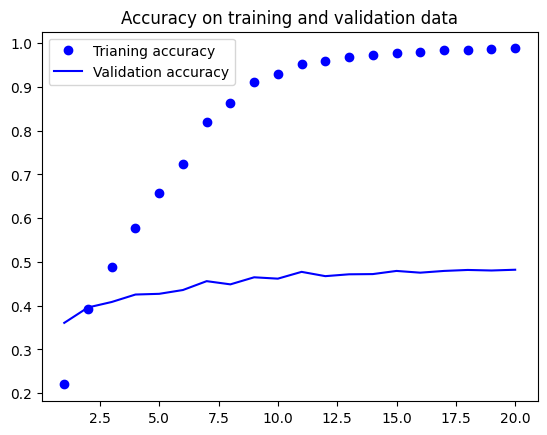

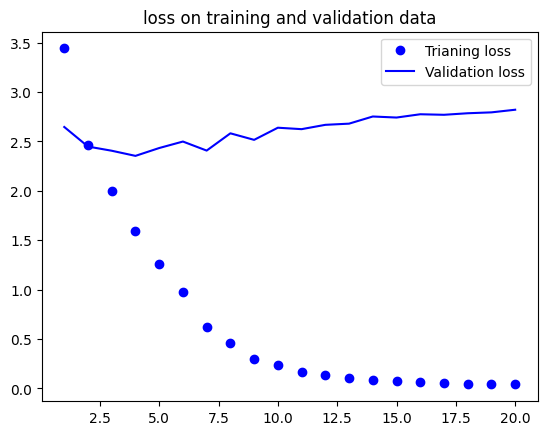

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

In [12]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(test_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

256/256 [==============================] - 145s 557ms/step - loss: 2.4238 - accuracy: 0.4153
The accuracy of the mobilenet model on the test set is : 0.415


# Making tests to model

In [24]:
testr_directory = 'testr_data'

testr_generator = general_datagen.flow_from_directory(
    testr_directory,
    target_size = (224, 224),
    batch_size = 1
)

categories = os.listdir(testr_directory) # list the names of the categories that in my data
print(str(len(categories)),'CATEGORIES are ', categories)

Found 1 images belonging to 2 classes.
2 CATEGORIES are  ['.ipynb_checkpoints', 'bird']


## A test for predicting one bird at a time

1/1 [==============================] - 1s 594ms/step
Class: Dryobates, Probability: 93%
Class: Dendrocopos, Probability: 2%
Class: Picoides, Probability: 0%


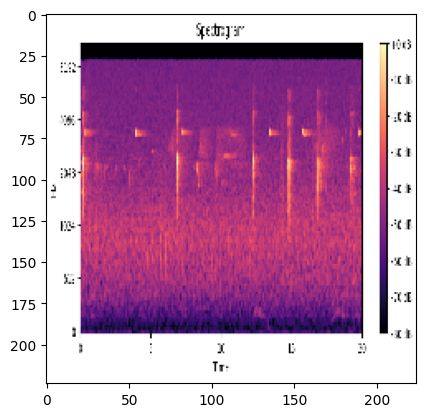

In [25]:
from tensorflow.keras.models import load_model

# Load the MobileNet model from the file
mobilenet_model = load_model('mobilenet_model.keras')

# Assuming 'testr_generator' is a generator that provides test images
plot_image(testr_generator)

# Assuming 'testr_generator' is a generator that provides test images
test_image = testr_generator[0][0]

# Get prediction from the model
prediction = mobilenet_model.predict(test_image)

# Get the predicted class probabilities for all classes
predicted_probabilities = prediction[0]

# Get the predicted class probability indices in descending order
predicted_class_probability = np.argsort(predicted_probabilities)[::-1]

# Select the top three classes with the highest probabilities
top_three_indices = predicted_class_probability[:3]

# Load the class labels from the "Birds_Order.txt" file
with open('Birds_Order.txt', 'r') as f:
    class_labels = [line.strip().split('. ')[1] for line in f]

# Get the class labels for the top three classes
top_three_labels = [class_labels[i] for i in top_three_indices]

# Get the corresponding probabilities
top_three_probabilities = [predicted_probabilities[i] for i in top_three_indices]

# Print the predicted labels and probabilities
for label, probability in zip(top_three_labels, top_three_probabilities):
    print(f"Class: {label}, Probability: {int(probability * 100)}%")